In [2]:
import numpy as np
import torch
from tensordict import TensorDict
from torch import Tensor
from torch.nn import Module
import matplotlib.pyplot as plt
import numpy as np
import torch
from tensordict import TensorDict
from torch import Tensor
from torch.nn import Module, ModuleList, Parameter
from nigbms.modules.constructors import SinCodec

In [3]:

class Codec(Module):
    def __init__(self, param_dim: int, latent_dim: int) -> None:
        """Initialize the codec.

        Args:
            param_dim (int): solver parameter dimension
            latent_dim (int): latent dimension
        """
        super().__init__()
        assert param_dim >= latent_dim
        self.param_dim = param_dim
        self.latent_dim = latent_dim

    def forward(self, x: Tensor) -> Tensor:
        raise NotImplementedError

    def encode(self, x: Tensor) -> Tensor:
        raise NotImplementedError

    def decode(self, z: Tensor) -> Tensor:
        raise NotImplementedError

class SinCodec(Codec):
    def __init__(self, param_dim: int = 128, latent_dim: int = 128):
        super().__init__(param_dim, latent_dim)
        frequencies = torch.arange(1, latent_dim + 1).unsqueeze(-1)  # (latent_dim, 1)
        phases = (torch.tensor([i / (param_dim + 1) for i in range(1, param_dim + 1)]) * torch.pi).unsqueeze(
            0
        )  # (1, param_dim)
        self.basis = torch.sin(frequencies * phases)  # (latent_dim, param_dim)
        self.basis = self.basis.unsqueeze(0)  # (1, latent_dim, param_dim) to broadcast for batch
        self.basis = self.basis/self.basis.norm(dim=-1, keepdim=True)  # normalize basis
        self.basis = Parameter(self.basis, requires_grad=False)  # set as fixed parameter to move to cuda

    def encode(self, x: Tensor) -> Tensor:
        x = x.reshape(-1, self.param_dim, 1)
        z = torch.matmul(self.basis, x).squeeze(-1)
        return z

    def decode(self, z: Tensor) -> Tensor:
        z = z.reshape(-1, self.latent_dim, 1)
        x = torch.matmul(self.basis.transpose(1, 2), z).squeeze(-1)
        return x

In [4]:
latent_dim = 32
param_dim = 128
codec = SinCodec(param_dim, latent_dim)

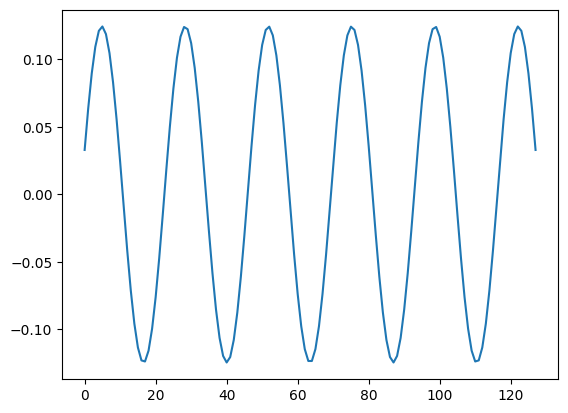

In [5]:
plt.plot(codec.basis[0,10])

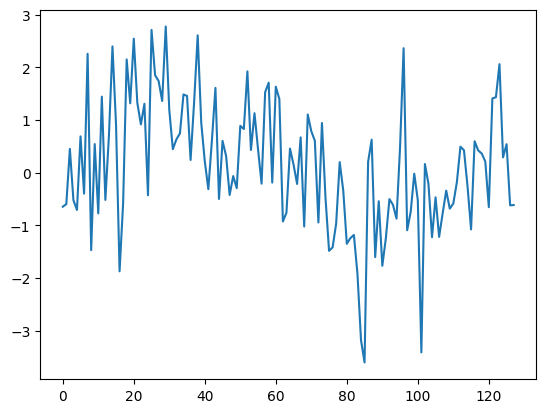

In [6]:
x = torch.randn(3, param_dim) + torch.sin(torch.linspace(0, 2*np.pi, param_dim))
plt.plot(x[0, :])

In [7]:
z = codec.encode(x)

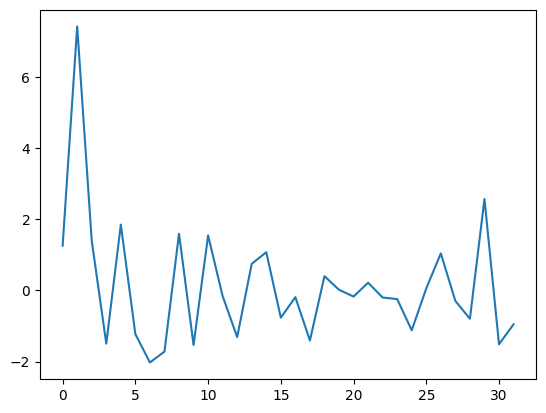

In [8]:
plt.plot(z[0])

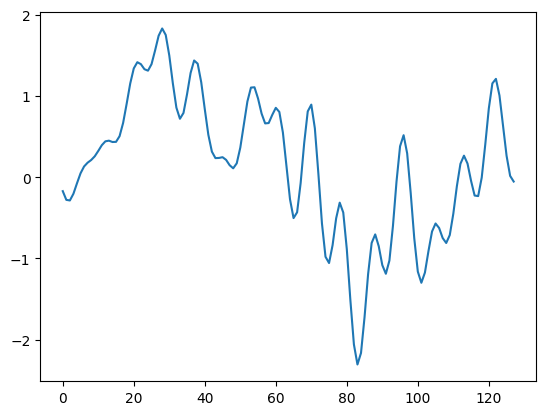

In [9]:
x_reconstructed = codec.decode(z)
plt.plot(x_reconstructed[0])

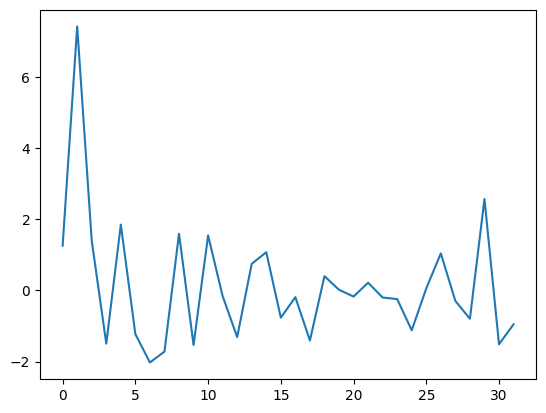

In [10]:
z_reconstructed = codec.encode(x_reconstructed)
plt.plot(z_reconstructed[0])

In [11]:
z_reconstructed

tensor([[ 1.2579,  7.4153,  1.3976, -1.4956,  1.8477, -1.2281, -2.0248, -1.7199,
          1.5909, -1.5314,  1.5444, -0.1603, -1.3122,  0.7473,  1.0723, -0.7649,
         -0.1894, -1.4085,  0.4009,  0.0177, -0.1725,  0.2162, -0.1998, -0.2438,
         -1.1215,  0.0567,  1.0403, -0.2961, -0.7965,  2.5682, -1.5130, -0.9527],
        [ 0.1721,  8.3679,  0.4642, -1.2068, -0.3232,  1.5436,  0.1618, -1.1770,
          0.6371, -0.6160, -0.4247, -0.4393, -0.6173, -0.3747,  0.2748,  0.2870,
          0.9356, -0.1700,  0.1835,  0.3910,  0.8281,  0.1002, -0.0850,  0.1574,
          0.3881,  0.6482,  1.3774, -0.7491, -0.4652, -0.6964, -1.0407, -1.0032],
        [ 0.4246,  7.7260,  1.5039, -0.2157,  1.8444, -0.3136,  0.7194,  2.0376,
         -0.0658,  0.9700,  0.0516,  2.3939,  0.2659,  0.7982,  0.0527, -0.9631,
         -0.8859, -0.1816, -0.5788,  0.1943, -1.2712,  1.1805,  0.6302, -1.8387,
         -1.2860,  1.2411,  0.6586,  1.1047, -1.1441,  0.0386, -0.8470,  0.3248]])

In [12]:
x.shape

torch.Size([3, 128])

In [13]:
x.reshape(-1, 1, param_dim)
x_inter = torch.nn.functional.interpolate(x.reshape(-1, 1, param_dim), size=latent_dim)

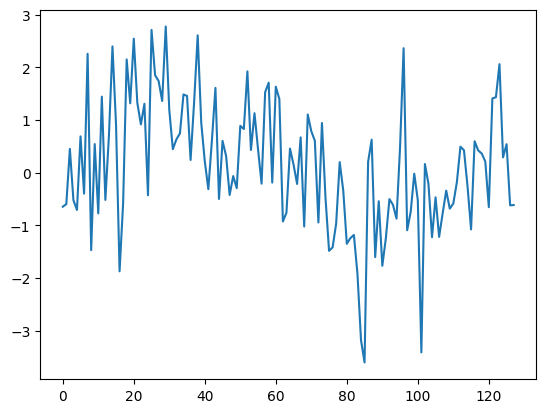

In [14]:
plt.plot(x[0])

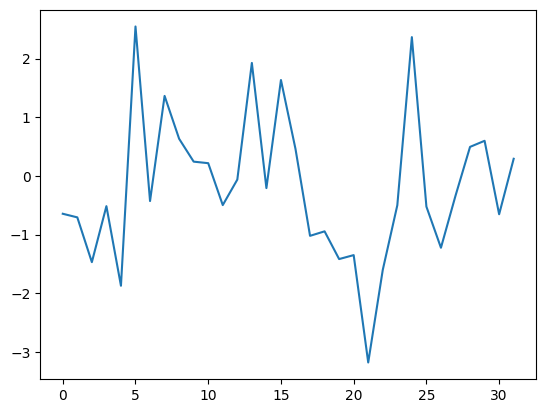

In [15]:
plt.plot(x_inter[0, 0])

In [16]:
from torch.nn.functional import interpolate

class LinearCodec(Codec):
    def __init__(self, param_dim: int = 128, latent_dim: int = 128):
        super().__init__(param_dim, latent_dim)

    def encode(self, x: Tensor) -> Tensor:
        z = interpolate(x.reshape(-1, 1, self.param_dim), size=self.latent_dim, mode='linear')
        return z

    def decode(self, z: Tensor) -> Tensor:
        x = interpolate(z.reshape(-1, 1, self.latent_dim), size=self.param_dim, mode='linear')
        return x

class FFTCodec(Codec):
    def __init__(self, param_dim: int = 128, latent_dim: int = 128):
        super().__init__(param_dim, latent_dim)
        assert latent_dim % 2 == 0

    def encode(self, x: Tensor) -> Tensor:
        z = torch.fft.rfft(x, dim=-1)[..., : self.latent_dim // 2]
        z = torch.view_as_real(z).reshape(-1, self.latent_dim)
        return z

    def decode(self, z: Tensor) -> Tensor:
        z = torch.view_as_complex(z.reshape(-1, self.latent_dim // 2, 2))
        x = torch.fft.irfft(z, n=self.param_dim)
        return x

In [17]:
codec = FFTCodec(param_dim, param_dim)
print(param_dim)

128


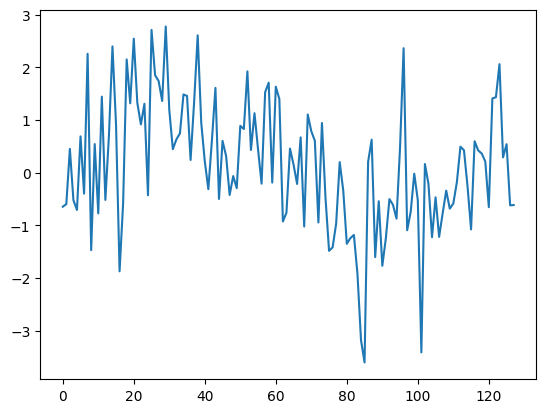

In [18]:
plt.plot(x[0])

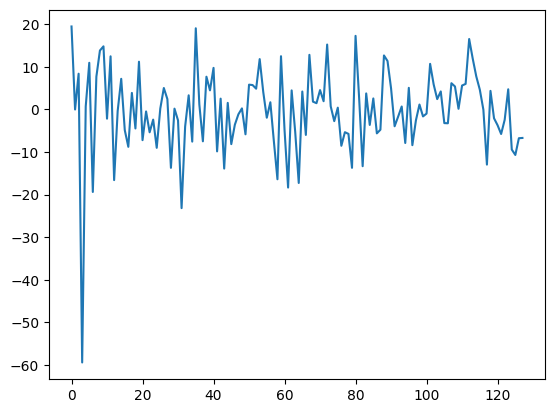

In [19]:
z = codec.encode(x)
plt.plot(z[0])

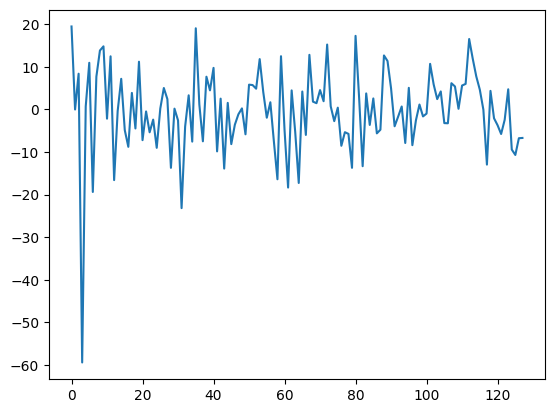

In [20]:
plt.plot(z[0])

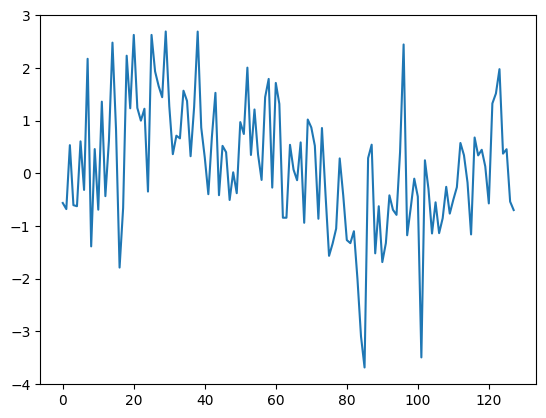

In [21]:
plt.plot(codec.decode(z)[0])

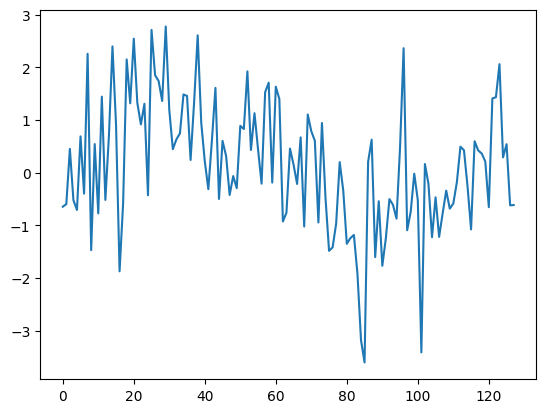

In [22]:
plt.plot(x[0])

In [22]:
codec = FFTCodec(param_dim, latent_dim)

In [24]:
x.shape

torch.Size([3, 128])